In [1]:
!pip install trimesh pandas scikit-learn gradio matplotlib joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 707.0/707.0 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machin

In [2]:
import os
import pandas as pd
import trimesh
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score, recall_score, precision_score
import joblib
import gradio as gr

# Set folder paths
obj_folder = '/content/drive/MyDrive/Dropbox_Data/tested'
excel_path = '/content/drag coefficients.xlsx'

In [3]:
# Load Excel file and preprocess it
df = pd.read_excel(excel_path)
df.rename(columns={'file':'filename'}, inplace=True)  # Rename the column to 'filename'
df['filename'] = df['filename'].apply(lambda x: x.split('.')[0])  # Remove .obj extension
df = df.drop('s.no', axis=1, errors='ignore')  # Drop 's.no' column, if exists

# Extract matching filenames
excel_filenames = set(df['filename'])
obj_filenames = set([f.split('.')[0] for f in os.listdir(obj_folder) if f.endswith(('.obj','.stl'))])
matching_filenames = excel_filenames.intersection(obj_filenames)

# Filter DataFrame for matching filenames
df_matching = df[df['filename'].isin(matching_filenames)]
valid_file_paths = [os.path.join(obj_folder, f"{filename}.obj") for filename in df_matching['filename']]

# Print matching details
print(f"Matching files: {matching_filenames}")

Matching files: {'65a4470657a736497c868c9d7b6906fc_aug', 'e7add7a018da8056bda733a39f84326d', 'cf9e82b3235f62c949956811ccd3041', 'a03c7c73c067afa9e5bf84cdd88910df', '42071d127c13becbecf71e2e014ff6f_aug', '957a686c3c9f956a3d982653fc5fd75b', '56478692749392a19dfd5136ef0f2af', '5494ca610eb9fad59bd53ddfa65bb6b1_aug', 'd014af11d76dbf667aaf79c2db0c7371', '7c6c0aee71bab292992363f03bd425c9', 'fe8e2a6c3a71608d7755e7baabe8a6f_aug', 'e624da8cd22f6d289bc0c5b67eaafbc', '12d7c4013415ea147f5b0cb87a91de52_aug', '846e6c678f53bf422e877e82c90c24d_aug', '97b18feaafcac6aa4f0317cecc837930', '2999f005f1eba724bda733a39f84326d', '4bb9baa521b7717c6436916a86a90ed7', '90f2e2d8f9b89074425b2c354eccabaf', '3359894ee08dac426436916a86a90ed7', '12243301d1c8148e33d7c9e122eec9b6', '31bfd930c2c612b4320fa6e2cd857828', '8824c06f737f2888e35db9103756ad5_aug', '79763b6b5eb6cfe8c805dfe4ca9f2fdb', '84079be86a25cb088132ec33ee4e535f', '6c50a9b8e01fbca27dfb1ee6a4b12bf8_aug', '57b8d6a0e58f7f5712da0dbf3c68e847', 'f689884daef74102179b4

In [4]:
def extract_features(file_path):
    try:
        mesh = trimesh.load(file_path)
    except Exception as e:
        return None  # Return None if there's an error loading the mesh

    # Surface Area
    area = mesh.area

    # Volume
    volume = mesh.volume

   # Bounding Box Properties
    bbox = mesh.bounds
    length = bbox[1][0] - bbox[0][0]
    width = bbox[1][1] - bbox[0][1]
    height = bbox[1][2] - bbox[0][2]
    bbox_volume = length * width * height

    # Aspect Ratio
    aspect_ratio = length / height if height != 0 else 0

    # Number of Vertices & Faces
    num_vertices = len(mesh.vertices)
    num_faces = len(mesh.faces)

    # Return as a feature list
    return [area, volume, bbox_volume, aspect_ratio, num_vertices, num_faces]

In [5]:
# Extract features from valid .obj files and prepare training data
features_list = []
for file_path in valid_file_paths:
    features = extract_features(file_path)
    if features is not None:
        features_list.append(features)

# Convert to DataFrame
feature_columns = ['area', 'volume', 'bbox_volume', 'aspect_ratio', 'num_vertices', 'num_faces']
features_df = pd.DataFrame(features_list, columns=feature_columns)
cd_values = df_matching['Cd'].values

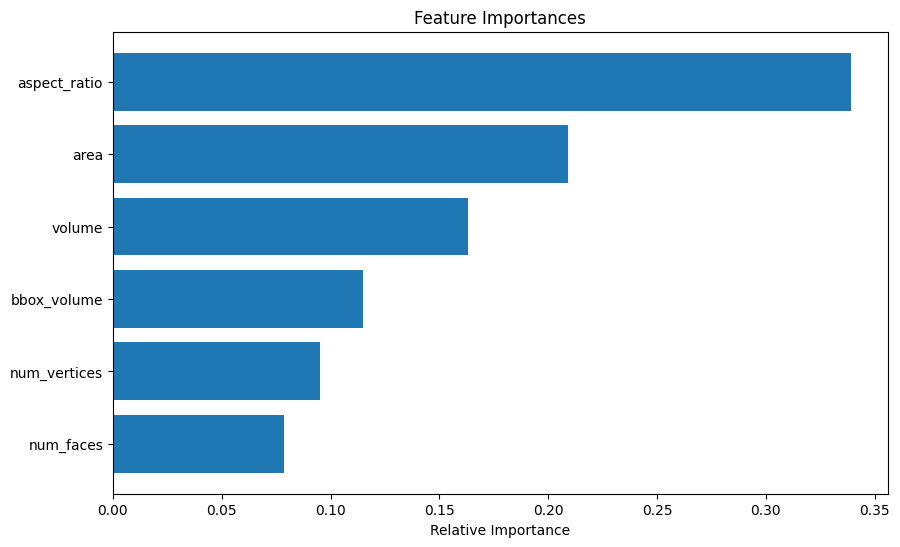

Selected Features: ['num_faces', 'num_vertices', 'bbox_volume', 'volume', 'area', 'aspect_ratio']


RandomForestRegressor(random_state=42)

In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_df, cd_values, test_size=0.2, random_state=42)

# Train a RandomForestRegressor to get feature importances
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Feature importance plot
importances = model.feature_importances_
indices = np.argsort(importances)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [feature_columns[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

# Display the most important features
selected_features = [feature_columns[i] for i in indices if importances[i] > 0.05]  # Only select features with importance > 0.05
print(f"Selected Features: {selected_features}")

# **New Training Step**
X_train_selected = X_train[selected_features]
model_selected = RandomForestRegressor(random_state=42)
model_selected.fit(X_train_selected, y_train)

In [7]:
# Evaluate the model
y_pred = model_selected.predict(X_test[selected_features])

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


# Calculate classification metrics at threshold 0.5
threshold = 0.5
y_pred_class = (y_pred > threshold).astype(int)
y_test_class = (y_test > threshold).astype(int)

accuracy = accuracy_score(y_test_class, y_pred_class)
f1 = f1_score(y_test_class, y_pred_class)
recall = recall_score(y_test_class, y_pred_class)
precision = precision_score(y_test_class, y_pred_class)

print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9441


In [8]:
# Save the best model
joblib.dump(model_selected, '/content/drag_coefficient_model.pkl')

['/content/drag_coefficient_model.pkl']

In [9]:
# Load the trained model
model = joblib.load('/content/drag_coefficient_model.pkl')

# Function to predict Cd from an uploaded file
def predict_cd(file):
    try:
        # Extract features from the uploaded .obj or .stl file
        mesh = trimesh.load(file.name)

        # Extract features
        area = mesh.area
        volume = mesh.volume
        bbox = mesh.bounds
        length = bbox[1][0] - bbox[0][0]
        width = bbox[1][1] - bbox[0][1]
        height = bbox[1][2] - bbox[0][2]
        bbox_volume = length * width * height
        aspect_ratio = length / height if height != 0 else 0
        num_vertices = len(mesh.vertices)
        num_faces = len(mesh.faces)


        # Prepare feature array
        features = np.array([[area, volume, bbox_volume, aspect_ratio, num_vertices, num_faces]])

        # Correct way to predict CD with selected features
        feature_indices = [feature_columns.index(feature) for feature in selected_features]
        cd_value = model.predict(features[:, feature_indices])[0]


        # Return the result
        result = f"Predicted Cd Value: {cd_value:.4f}\n\nFeatures:\n" \
                 f"Area: {area:.4f}, Volume: {volume:.4f}, Bounding Box Volume: {bbox_volume:.4f}, Aspect Ratio: {aspect_ratio:.4f} " \
                  f"Num Vertices: {num_vertices}, Num Faces: {num_faces}"


        return result
    except Exception as e:
        return f"Error in processing the file: {str(e)}"

In [10]:
# Gradio interface
gr.Interface(fn=predict_cd, inputs=gr.File(label="Upload 3D Model (obj/stl)"),
             outputs=gr.Textbox(label="Predicted Cd and Features"),
             title="Aero-Predict 🚀",
             description="Welcome to Aero-Predict! This web app predicts the drag coefficient (Cd) of 3D models "
                         "in .obj or .stl format based on geometric features. Upload your model and get the predicted Cd value and key features.",
             theme="compact").launch()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gradio/blocks.py:1057: UserWarning: Cannot load compact. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/compact (Request ID: Root=1-679deb19-1e3a34e577c39f3b350394e9;3af43939-31dd-4156-aa83-47296e0060a4)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0e90f50be953b1d54a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
